In [1]:
import pyro
import torch
import normflows as nf
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
import yaml
import corner
import random
import numpy as np
mpl.rcParams["figure.dpi"] = 100

from grad_june import Runner

#torch.autograd.detect_anomaly(check_nan=True)

In [2]:
def set_random_seed(seed=999):
    """
    Sets global seeds for testing in numpy, random, and numbaized numpy.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    return
set_random_seed()

In [3]:
def plot_posterior(nfm, it):
    posteriors = nfm.sample(10000)
    samples = posteriors[0].cpu().detach().numpy()
    samples = np.where(~np.isnan(samples), samples, 0)
    samples = np.where(~np.isinf(samples), samples, 0)
    samples = np.where(np.abs(samples) < 5, samples, 0)
    f = corner.corner(samples, labels = param_names, 
                      smooth=2, 
                      truths=true_values,
                      show_titles=True,
                      bins=30,
                      range = [(-4,4) for i in range(len(true_values))])
    #f.savefig(f"./flow_results/posteriors/posterior_{it:03d}.png", dpi=150, facecolor='white')
    return

In [4]:
device = "cpu"

In [5]:
true_parameters = {
  #"care_home":
  #  {"log_beta": 1.3054601},
  #"care_visit":
  #  {"log_beta": 0.46661767},
  #"cinema":
  #  {"log_beta": 0.7523964},
  #"company":
  #  {"log_beta": 0.3428555},
  #"grocery":
  #  {"log_beta": 0.7523964},
  #"gym":
  #  {"log_beta": 0.7523964},
  "household":
    {"log_beta": 1.30810425},
  #"pub":
  #  {"log_beta": 0.7523964},
  #"school":
  #  {"log_beta": 0.4572914},
  #"university":
  #  {"log_beta": 0.34417054},
  #"visit":
  #  {"log_beta": 0.7523964},
}
n_true_parameters = len(true_parameters)
true_values = np.array([true_parameters[key]["log_beta"] for key in true_parameters])
param_names = list(true_parameters.keys())
n_true_parameters
true_values

array([1.30810425])

In [6]:
#params = yaml.safe_load(open("../configs/june.yaml"))
params = yaml.safe_load(open("../configs/best_run.yaml"))
params["timer"]["total_days"] = 30
params["system"]["device"] = "cpu"
params["data_path"] = "/Users/arnull/code/gradabm-june/test/data/data.pkl"
for key in true_parameters:
    params["networks"][key] = true_parameters[key]
runner = Runner.from_parameters(params)

In [7]:
true_data = runner()[0]["cases_per_timestep"]

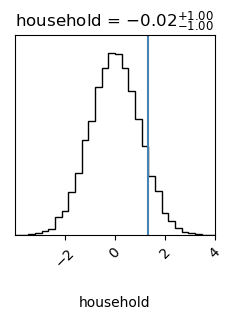

In [8]:
# Set up model

# Define flows
K = 4

latent_size = len(true_values)
hidden_units = 16
hidden_layers = 2

flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set prior and q0
q0 = nf.distributions.DiagGaussian(len(true_values), trainable=False)

# Construct flow model
flow = nf.NormalizingFlow(q0=q0, flows=flows)

# Move model on GPU if available
enable_cuda = True
flow = flow.to(device)

plot_posterior(flow, 0)
plt.show()

In [9]:
def run_model(sample):
    #print(sample)
    for (j, name) in enumerate(true_parameters):
        runner.model.infection_networks.networks[name].log_beta = sample[j]
    cases_per_timestep = runner()[0]["cases_per_timestep"]
    return cases_per_timestep

def get_forecast_score(flow, true_data, loss_fn, n_samples=5):
    loss = 0.0
    for i in range(n_samples):
        sample, lp = flow.sample()
        #print(sample)
        cases_per_timestep = run_model(sample)
        #print(cases_per_timestep)
        loss += loss_fn(cases_per_timestep, true_data)
        #print(loss)
    return loss / n_samples

def get_regularisation(flow, true_data, n_samples=5, summarise_cond=True):
    samples, lps = flow.sample(n_samples)
    #log_flow = 0.
    #for i in range(n_samples):
    #for j in range(true_data.shape[0]):
    #    log_flow += flow.log_prob(samples[i]).sum()
    #log_flow /= (n_samples)
    lps = torch.sum(lps) / n_samples
    # Empirical mean of log of prior – uniform, so just constant/no contribution since we assume all
    # flow samples are within prior support, even if only thanks to the clipping
    log_prior = 0.
    return lps - log_prior


In [10]:
# Train model

parameters_to_optimize = list(flow.parameters())
optimizer = torch.optim.Adam(parameters_to_optimize, lr=1e-3)
loss_fn = torch.nn.MSELoss(reduction="mean")


n_epochs = 50
n_samples_per_epoch = 10

best_loss = np.inf
loss_hist = []
loss_hist_train = []

w = torch.tensor(0., requires_grad=True)

iterator = tqdm(range(n_epochs))

for it in iterator:
    optimizer.zero_grad()
    forecast_loss = get_forecast_score(flow=flow, true_data=true_data, loss_fn=loss_fn, n_samples=n_samples_per_epoch)
    reglrise_loss = get_regularisation(flow=flow, true_data=true_data, n_samples=n_samples_per_epoch)
    loss = forecast_loss  + w * reglrise_loss
    #print(loss)
    if torch.isnan(loss):
        print("loss is nan!")
        break
    loss.backward()
    
    for name, param in flow.named_parameters():
        if not torch.isfinite(param.grad).all():
            print(name)

    #torch.nn.utils.clip_grad_norm_(parameters_to_optimize, 1e-3)
    loss_hist_train.append(loss.item())
    optimizer.step()
    
    with torch.no_grad():
        val_forecast_loss = get_forecast_score(flow=flow, true_data=true_data, loss_fn=loss_fn, n_samples=n_samples_per_epoch)
        val_reglrise_loss = get_regularisation(flow=flow, true_data=true_data, n_samples=n_samples_per_epoch)
        val_loss = val_forecast_loss + w * val_reglrise_loss
        
        loss_hist.append(val_loss.item())
        if val_loss.item() < best_loss:
            torch.save(flow.state_dict(), "./best_model.pth")
            best_loss = val_loss.item()
        iterator.set_postfix({"fl":forecast_loss.item(), 
                              "rl":reglrise_loss.item(), 
                              "val loss":val_loss.item(), 
                              "best val loss":best_loss})

100%|████| 50/50 [01:11<00:00,  1.44s/it, fl=608, rl=-.94, val loss=1.12, best val loss=1.12]


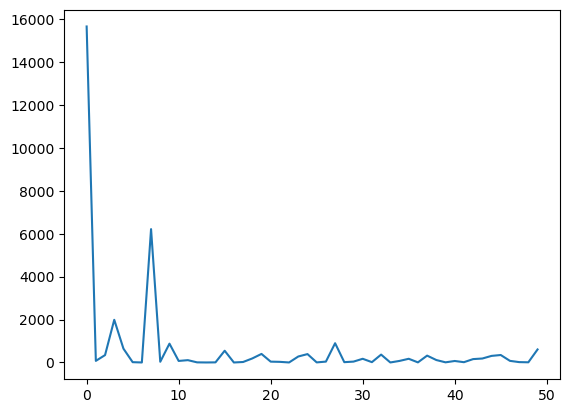

In [11]:
plt.plot(loss_hist_train)

In [12]:
flow.load_state_dict(torch.load("./best_model.pth"))

<All keys matched successfully>

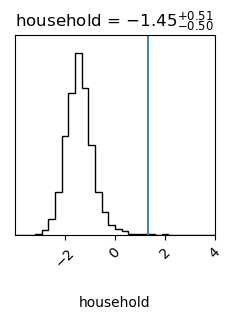

In [13]:
plot_posterior(flow, 0)